# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [16]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [24]:
#TODO: Fetch and upload the data to AWS S3
!aws s3 sync './dogImages/' 's3://sagemaker-us-east-1-265345480326/project_3/'

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/002.Afghan_hound/Afghan_hound_00139.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-265345480326/project_3/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/002

In [2]:



# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-01-21 08:11:15--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.7MB/s    in 25s     

2023-01-21 08:11:50 (43.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [17]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "project_3"

## Webdataset Creation and store into S3
* I used a webdataset to upload data into S3 bucket; in this way I can retrieve dataset and then create a dataloader for efficeint training

In [2]:
!pip install webdataset

  Using cached webdataset-0.2.31-py3-none-any.whl (50 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


In [13]:
import webdataset as wds
import torchvision
from glob import glob

In [9]:
train_folder = './dogImages/train'
# Create a list of all files in all folders/classes
basenames = glob(train_folder + '/**/*.jpg')

In [18]:
test_folder = './dogImages/test'
basenames_test = glob(test_folder + '/**/*.jpg')

In [25]:
# Extract the class type from folder name
def lookup_cls(basename):
  return basename.split('/')[-2].split('.')[0].encode('ascii')

In [26]:
# Creazione archivio tar con immagini e classi
def create_webdataset(basenames, output_path):
    #sink = wds.TarWriter('./dogImages_dataset.tar')
    sink = wds.TarWriter(output_path)
    for basename in basenames:
        with open(f"{basename}", "rb") as stream:
            image = stream.read()
        cls = lookup_cls(basename)
        sample = {
            "__key__": basename,
            "input.jpg": image,
            "target.cls": cls
        }
        sink.write(sample)
    sink.close()

In [ ]:
# Create webdataset for train
create_webdataset(basenames=basenames, output_path='./dogImages_dataset.tar')

In [27]:
# Create webdataset for test
create_webdataset(basenames=basenames_test, output_path='./dogImages_dataset_test.tar')

In [18]:
# Upload tar webdataset into S3
inputs = sagemaker_session.upload_data(path='./dogImages_dataset.tar', bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-265345480326/project_3/dogImages_dataset.tar


In [103]:
#inputs = sagemaker_session.upload_data(path='./dogImages/', bucket=bucket, key_prefix=prefix)

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-265345480326/project_3


## Class type extraction

* I get in list_classe variable all the classes in train set
* I get in list_train_files variable all the path file in train set

In [100]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob
%matplotlib inline

In [6]:
local_path_train = './dogImages/train/'
local_path_test = './dogImages/test/'

In [7]:
list_classes = os.listdir(local_path_train)

In [8]:
list_train_files = glob(local_path_train+'/**/*.jpg', recursive=True)

In [9]:
print(list_classes)

['114.Otterhound', '110.Norwegian_lundehund', '127.Silky_terrier', '091.Japanese_chin', '095.Kuvasz', '061.English_cocker_spaniel', '043.Canaan_dog', '131.Wirehaired_pointing_griffon', '124.Poodle', '087.Irish_terrier', '053.Cocker_spaniel', '064.English_toy_spaniel', '105.Neapolitan_mastiff', '032.Boston_terrier', '017.Bearded_collie', '094.Komondor', '003.Airedale_terrier', '084.Icelandic_sheepdog', '122.Pointer', '098.Leonberger', '125.Portuguese_water_dog', '009.American_water_spaniel', '058.Dandie_dinmont_terrier', '115.Papillon', '006.American_eskimo_dog', '041.Bullmastiff', '085.Irish_red_and_white_setter', '081.Greyhound', '004.Akita', '103.Mastiff', '044.Cane_corso', '118.Pembroke_welsh_corgi', '013.Australian_terrier', '117.Pekingese', '002.Afghan_hound', '025.Black_and_tan_coonhound', '129.Tibetan_mastiff', '093.Kerry_blue_terrier', '023.Bernese_mountain_dog', '070.German_pinscher', '052.Clumber_spaniel', '048.Chihuahua', '088.Irish_water_spaniel', '050.Chinese_shar-pei', '1

In [11]:
list_classes_elab = [x.split('.') for x in list_classes]

In [12]:
df_class = pd.DataFrame(list_classes_elab, columns=['class_id','class_descr'])
#df_class = df_class.sort_values(by=['class_id'])


In [13]:
df_class.head()

,class_id,class_descr
0,114,Otterhound
1,110,Norwegian_lundehund
2,127,Silky_terrier
3,091,Japanese_chin
4,095,Kuvasz


In [14]:
# Add the column num files for each class
num_files = []
for i, classe in enumerate(list_classes):
    num_files.append(len(os.listdir(local_path_train + classe)))

In [93]:
df_class['num_files'] = num_files

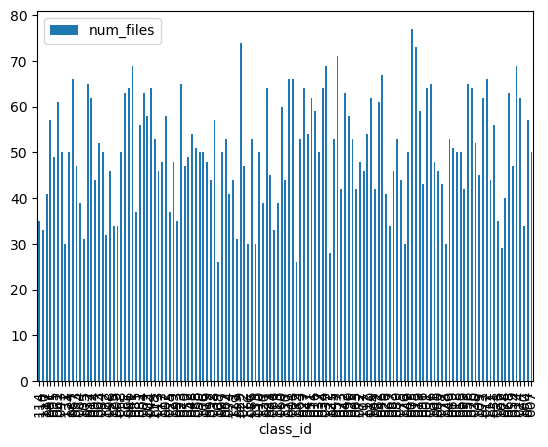

In [98]:
df_class.plot.bar(x='class_id', y='num_files')

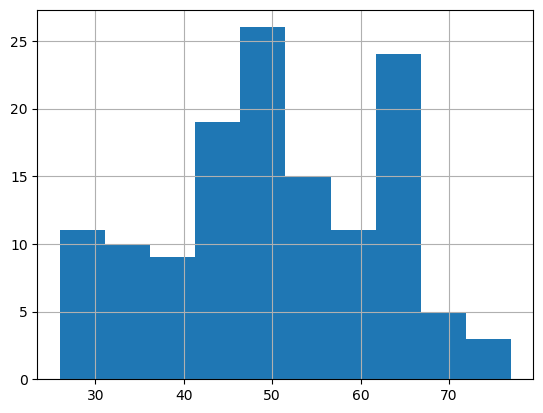

In [99]:
df_class['num_files'].hist()

## Data visualization

* Random visualization of a grid 3x3 of images

In [15]:
random_imgs = np.random.randint(0, len(list_train_files), 9)

In [16]:
list_train_files[random_imgs[0]]

'./dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03880.jpg'

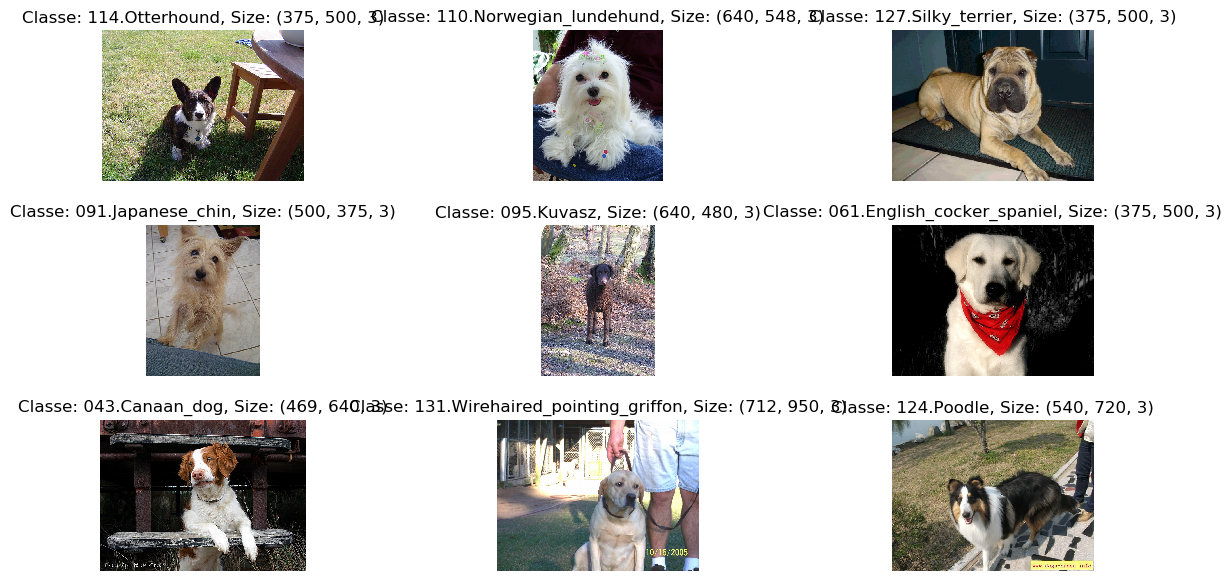

In [18]:
fig, axs = plt.subplots(3,3, figsize=(12,6))
plt.tight_layout()
axs = axs.ravel()
random_imgs = np.random.randint(0, len(list_train_files), 9)

for i, ax in enumerate(axs):
    img = mpimg.imread(list_train_files[random_imgs[i]])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Classe: {list_classes[i]}, Size: {img.shape}')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [42]:
!pip install webdataset

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00


In [59]:
!pip install torchdata

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 35.0 MB/s eta 0:00:0000:0100:01


### Test: Dataloader creation from S3 bucket
link: 
* https://towardsdatascience.com/training-in-pytorch-from-amazon-s3-6156d5342d1
* https://docs.aws.amazon.com/lookout-for-vision/latest/developer-guide/create-dataset-s3.html
* https://aws.amazon.com/it/blogs/machine-learning/announcing-the-amazon-s3-plugin-for-pytorch/

In [3]:
!pip install webdataset

  Using cached webdataset-0.2.31-py3-none-any.whl (50 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


In [14]:
!pip install torchvision

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)


In [19]:
!pip install torch

Keyring is skipped due to an exception: 'keyring.backends'


In [4]:
# Test Create Dataloader from S3 bucket
import imageio
import io
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import webdataset as wds

In [5]:
# Definisce una map su ogni elemento Resize immagine
def preprocess(sample):
    image, cls = sample
    #image = T.Resize(size=(224,224))(T.ToTensor()(image))
    image = T.ToTensor()(image)
    image = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    image = T.Resize(size=(224,224))(image)
    label = cls
    
    return 1-image, label

In [6]:
# Carica un archivio TAR dal cloud, tipo IterableDataset

url = "https://sagemaker-us-east-1-265345480326.s3.amazonaws.com/project_3/dogImages_dataset.tar"
# url = "./dogImages_dataset.tar"

dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("jpg.input.jpg", "jpg.target.cls").map(preprocess)
dataset = dataset.batched(16)

[2023-01-24 15:10:43.466 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:99 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-24 15:10:43.790 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:99 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


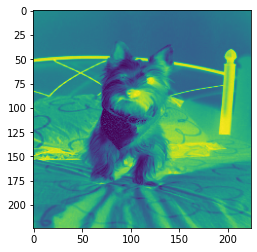

In [7]:
# Recupero il primo campione del dataset
tmp = next(iter(dataset))
# Mostra immagine
plt.imshow(tmp[0][0,0,:,:])

In [8]:
# Loader definition
loader = wds.WebLoader(dataset, num_workers=2, batch_size=None)
loader = loader.unbatched().shuffle(1000).batched(12)

In [12]:
loader.len

AttributeError: 'WebLoader' object has no attribute 'len'

In [18]:
# Visualizzare il loader
batch = next(iter(loader))
batch[0].shape, batch[1]

(torch.Size([12, 3, 224, 224]),
 tensor([114, 127, 127, 114, 114, 127, 114, 114,  61, 114,  61,  61]))

In [20]:
for batch_idx, (data, target) in enumerate(loader):
    print(data.shape, target)
    break

torch.Size([12, 3, 224, 224]) tensor([114, 114,  61,  91,  91,  43, 110, 127, 127, 114,  91, 114])


In [22]:
def create_loader(url, batch_size):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    # Create Dataset from tar archive
    dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("jpg.input.jpg", "jpg.target.cls").map(preprocess)
    dataset = dataset.batched(16)
    
    # Create Loader
    loader = wds.WebLoader(dataset, num_workers=2, batch_size=None)
    loader = loader.unbatched().shuffle(1000).batched(batch_size)
    
    return loader

In [35]:
loader_example = None

In [38]:
loader_example = create_loader(url, 32)

In [39]:
# Visualizzare il loader
for batch_idx, (data, target) in enumerate(loader_example):
    print(data.shape, target)
    break

RuntimeError: DataLoader worker (pid(s) 296) exited unexpectedly

In [35]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [7]:
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
train_dataset = torchvision.datasets.ImageFolder(root='./dogImages/train', transform=training_transform)

In [11]:
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=16,
                    shuffle=True
                )

In [12]:
len(train_loader.dataset)

6680

In [13]:
len(train_loader)

418

In [27]:
def net():
    '''
    TODO: Complete this function that initializes your model
          Remember to use a pretrained model
    '''
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False   
    num_features=model.fc.in_features
    model.fc = nn.Sequential(
                   nn.Linear(num_features, 133))
    return model

In [30]:
model = net()

In [31]:
for batch_idx, (data, target) in enumerate(train_loader):
    output = model(data)
    break

[2023-01-24 17:50:33.735 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:33 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-24 17:50:33.959 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:33 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [36]:
loss = F.nll_loss(output, target)

In [39]:
# Recupero il primo campione del dataset
tmp = next(iter(train_dataset))
# Mostra immagine
print(tmp[1])

0


In [40]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [41]:
# Visualizzare il loader
batch = next(iter(trainloader))
batch[0].shape

torch.Size([16, 3, 224, 224])

## Fine tuning testing

In [48]:
!pip install torch

In [43]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [44]:
for param in model.parameters():
    param.requires_grad = False

In [50]:
import torch
from torch import nn

num_features=model.fc.in_features
print(num_features)
model.fc = nn.Sequential(nn.Linear(num_features, 133))

2048


## Definition of hpo, tuner and estimantor

In [2]:
import sagemaker

In [3]:
# Instatiate the tuner
from sagemaker.tuner import (
    ContinuousParameter, 
    CategoricalParameter, 
    HyperparameterTuner
)

In [4]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "project_3"

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([64, 128, 256]),
}

In [6]:
# Import Pytorch estimator
from sagemaker.pytorch import PyTorch

In [7]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", 
                       "Regex": "Test set: Average loss: ([-0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

# TODO: Your estimator here
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large'
)

In [9]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [10]:
inputs_train = 's3://sagemaker-us-east-1-265345480326/project_3/train/'
inputs_val = 's3://sagemaker-us-east-1-265345480326/project_3/valid/'

In [14]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs_train, "testing": inputs_val}, wait=True) # TODO: Remember to include your data channels__________________________________________________________________________________________________________

................................................................................................................................................................................................!


In [17]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO


2023-01-26 19:03:03 Starting - Preparing the instances for training
2023-01-26 19:03:03 Downloading - Downloading input data
2023-01-26 19:03:03 Training - Training image download completed. Training in progress.
2023-01-26 19:03:03 Uploading - Uploading generated training model
2023-01-26 19:03:03 Completed - Resource reused by training job: pytorch-training-230126-1853-003-91a06070


In [18]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'lr': '0.007817991165690649',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-26-18-52-59-862"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-265345480326/pytorch-training-2023-01-26-18-52-59-862/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [19]:
!pip install smdebug

In [20]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

In [21]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [22]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [25]:
hook_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': '100',
                    'eval.save_interval': '10'}
)

In [26]:
hyperparameters = {"epochs": "30", "batch-size": "128", "lr": "0.007817991165690649"}

In [27]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="project-3-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

In [28]:
inputs_train = 's3://sagemaker-us-east-1-265345480326/project_3/train/'
inputs_val = 's3://sagemaker-us-east-1-265345480326/project_3/valid/'

In [29]:
estimator.fit({"training": inputs_train, "testing": inputs_val}, wait=True)

2023-01-26 19:56:19 Starting - Starting the training job...
2023-01-26 19:56:46 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-01-26 19:57:46 Downloading - Downloading input data...
2023-01-26 19:58:15 Training - Downloading the training image......
2023-01-26 19:59:14 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-26 19:59:12,099 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-26 19:59:12,102 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-26 19:59:12,111 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-

In [30]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [31]:
path = estimator.latest_job_debugger_artifacts_path()
print('Tensors are stored in: {}'.format(path))

Tensors are stored in: s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-26-19-56-18-659/debug-output


In [32]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(path)

[2023-01-26 20:09:19.725 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:32 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-26 20:09:19.755 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:32 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-26-19-56-18-659/debug-output


In [38]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:265345480326:processing-job/project-3-pytorch-2023-01--vanishinggradient-257edc51',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 1, 26, 20, 6, 37, 823000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:265345480326:processing-job/project-3-pytorch-2023-01--overfit-9e568312',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 1, 26, 20, 6, 37, 823000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:265345480326:processing-job/project-3-pytorch-2023-01--overtraining-68b73290',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 1, 26, 20, 6, 37, 82300

In [33]:
trial.tensor_names()

[2023-01-26 20:09:28.778 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:32 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-26 20:09:29.798 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:32 INFO trial.py:210] Loaded all steps


['gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 '

In [34]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))

1

In [40]:
list(trial.tensor('nll_loss_output_0').values(mode=modes.TRAIN).values())

[array(1.0910769, dtype=float32)]

TensorUnavailable: Tensor CrossEntropyLoss_output_0 was not saved.

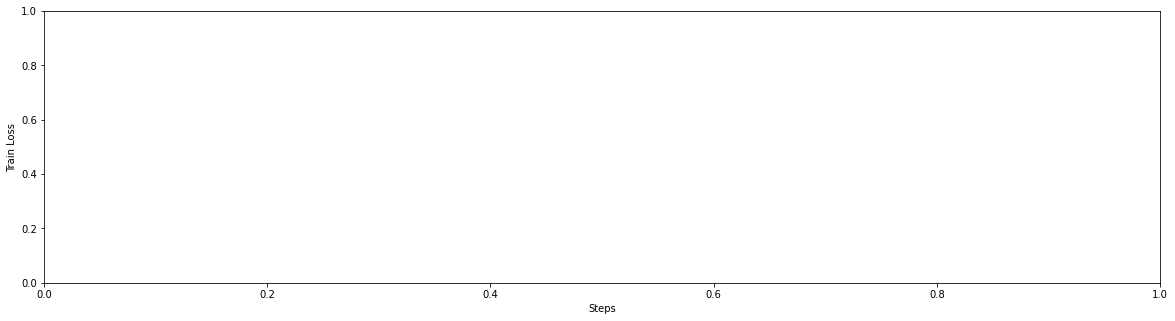

In [36]:
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()

In [28]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


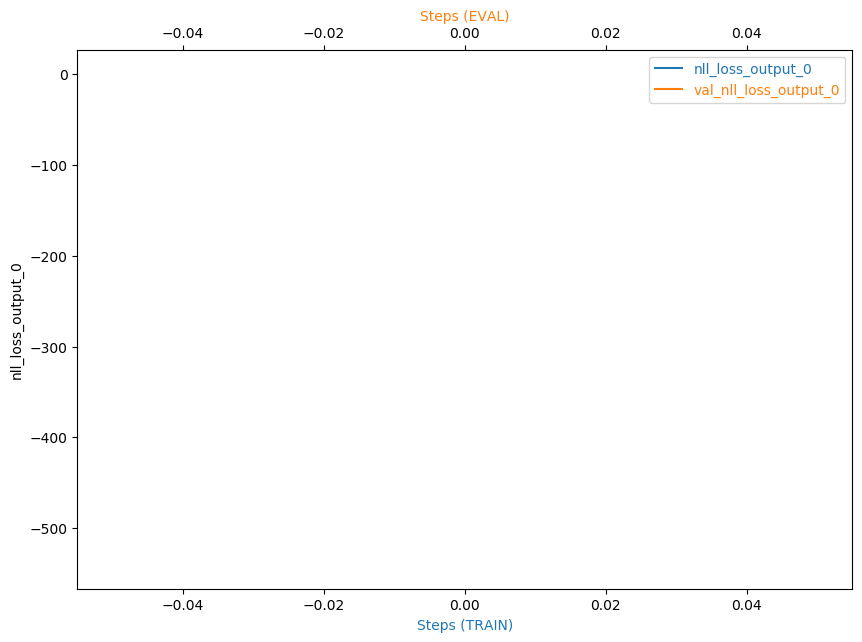

In [31]:
plot_tensor(trial, "nll_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [32]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [33]:
rule_output_path

's3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/rule-output'

In [34]:
! aws s3 ls {rule_output_path} --recursive

2023-01-25 05:58:35     329696 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-25 05:58:35     171054 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-25 05:58:31        191 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-25 05:58:31        199 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-25 05:58:31        126 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-25 05:58:31        127 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-25 05:58:31        198 project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/prof

In [35]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-265345480326/proj

In [36]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [37]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [18]:
S3_path_trained_model = 's3://sagemaker-us-east-1-265345480326/project-3-pytorch-2023-01-25-05-53-36-581/output/model.tar.gz'

In [5]:
# TODO: Deploy your model to an endpoint

# predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

#predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

predictor = sagemaker.predictor.Predictor(endpoint_name='project-3-pytorch-2023-01-25-19-28-49-224', sagemaker_session=sagemaker_session)

In [6]:
endpoint = predictor.endpoint_name
print(endpoint)

project-3-pytorch-2023-01-25-19-28-49-224


In [7]:
from PIL import Image

In [8]:
with Image.open('./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg') as im:
    im_resized = im.resize((224, 224))

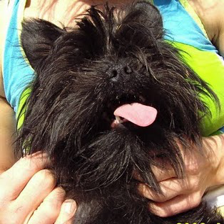

In [9]:
display(im_resized)

In [11]:
!pip install torchvision

In [53]:
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )

In [54]:
data = transform(Image.open('./dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg'))

In [ ]:
from sagemaker.serializers import IdentitySerializer

predictor.serializer = IdentitySerializer("image/png")

In [28]:
data = np.expand_dims(data, axis=0)

In [50]:
data.shape

torch.Size([3, 224, 224])

In [ ]:
# TODO: Run an prediction on the endpoint
import numpy as np

# TODO: Your code to load and preprocess image to send to endpoint for prediction
# response = predictor.predict(image)

response = predictor.predict(data)

In [ ]:
response

In [ ]:
# Deploy model

In [ ]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

role = get_execution_role() 
# You can also configure a sagemaker role and reference it by its name. 
# role = "CustomSageMakerRoleName"
pytorch_model = PyTorchModel(model_data='_____', role=role, entry_point='inference.py', framework_version='1.8')
predictor = pytorch_model.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()